In [68]:
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import plotnine as pn;
from datetime import datetime;
from dateutil.relativedelta import relativedelta
from sklearn.neighbors import NearestNeighbors;
from sklearn.linear_model import LinearRegression;

In [40]:
data = pd.read_csv("SPX_W_incomplete.csv")

#generate x values
date_grid = []
for i in np.arange(52):
    thisdate = ( datetime.strptime('2023-09-25', '%Y-%m-%d') + relativedelta(weeks = -int(i)) ).strftime('%F')
    date_grid.append(thisdate)
date_grid = np.asarray(date_grid, dtype=np.datetime64)
date_grid = np.flip(date_grid)

#fix date column in dataframe
data_date_Col = [];
for row in data["Date"]:
   thisdate = datetime.strptime(row[0:10], '%Y-%m-%d').strftime('%F')
   data_date_Col.append(thisdate)
data_date_Col = np.asarray(data_date_Col, dtype = np.datetime64)

data['Date'] = data_date_Col

In [57]:
K = 8;
#target weeks
weeks = np.arange(0, 52)
weekssq = weeks**2

##Find Nearest Neighbors
nn = NearestNeighbors(n_neighbors = K, p = 1).fit(np.asarray(data['WeekNumber']).reshape(-1, 1));
kn = nn.kneighbors(weeks.reshape(-1, 1), K, return_distance= True)

#find max distances - using the 8th nearest neighbor, neighbors in ascending order of distance
distances = kn[0]
maxdistances = np.expand_dims(kn[0][:,7], axis = 1)

#Get scaled distances
scaled_dist = distances/maxdistances


array([   0,    1,    4,    9,   16,   25,   36,   49,   64,   81,  100,
        121,  144,  169,  196,  225,  256,  289,  324,  361,  400,  441,
        484,  529,  576,  625,  676,  729,  784,  841,  900,  961, 1024,
       1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764, 1849,
       1936, 2025, 2116, 2209, 2304, 2401, 2500, 2601])

In [56]:
#tri-cube function
tricube = lambda distance_vec: np.power(1 - np.power(np.abs(distance_vec), 3), 3)

weights = tricube(scaled_dist)

weights.shape

(52, 8)

## Part [a]

## Part [b]

In [106]:
#generate actual neighborhoods and matrix of weights
neighborhoods_x = \
    np.asarray([np.asarray(data['WeekNumber'])[kn[1][i]] for i in range(len(weeks))])
neighborhoods_y = \
    np.asarray([np.asarray(data['Close'])[kn[1][i]] for i in range(len(weeks))])

predictions = [];
for i in range(len(weeks)):
    X_i = np.vstack((neighborhoods_x[i], neighborhoods_x[i]**2)).T
    regressor = LinearRegression().fit(X_i,neighborhoods_y[i], sample_weight = weights[i]);
    curr = [weeks[i], weekssq[i]]
    predictions.append(regressor.predict([curr]))

predictions = np.asarray(predictions).flatten()

In [103]:
data_report = pd.DataFrame(np.array([weeks, date_grid, predictions]).T, columns = ["Week Number", "Date", "Estimated Close"])
data_report

,Week Number,Date,Estimated Close
0,0,2022-10-03,3647.007581
1,1,2022-10-10,3711.426106
2,2,2022-10-17,3771.832046
3,3,2022-10-24,3828.86729
4,4,2022-10-31,3882.547696
5,5,2022-11-07,3928.248294
6,6,2022-11-14,3990.707024
7,7,2022-11-21,4034.93665
8,8,2022-11-28,4044.176762
9,9,2022-12-05,4016.05921


## Part [c]

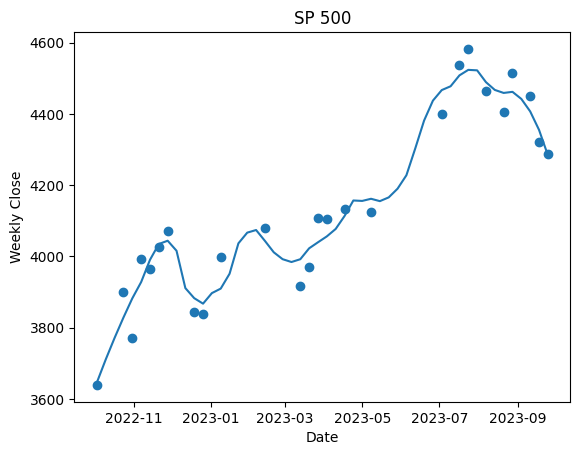

In [105]:
plt.scatter(data['Date'], data['Close'])
plt.plot(date_grid, predictions)
plt.xlabel('Date')
plt.ylabel('Weekly Close')
plt.title('SP 500')
plt.show()